# Fine-tune SAM on customized datasets (2D example)
1. Prepare original 2D images `data/MedSAMDemo_2D/` (Download link:https://drive.google.com/file/d/18GhVEODbTi17jSeBXdeLQ7vHPdtlTYXK/view?usp=share_link) 
2. Run `pre_grey_rgb2D.py` for pre-processing. Expected output: `./data/demo2D_vit_b/demo2d.npz`
3. Start this fine-tuning tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [2]:
#%% create a dataset class to load npz data and return back image embeddings and ground truth
class NpzDataset(Dataset): 
    def __init__(self, data_root):
        self.data_root = data_root
        self.npz_files = sorted(os.listdir(self.data_root)) 
        self.npz_data = [np.load(join(data_root, f)) for f in self.npz_files]
        # this implementation is ugly but it works (and is also fast for feeding data to GPU) if your server has enough RAM
        # as an alternative, you can also use a list of npy files and load them one by one
        self.ori_gts = np.vstack([d['gts'] for d in self.npz_data])
        self.img_embeddings = np.vstack([d['img_embeddings'] for d in self.npz_data])
        print(f"{self.img_embeddings.shape=}, {self.ori_gts.shape=}")
    
    def __len__(self):
        return self.ori_gts.shape[0]

    def __getitem__(self, index):
        img_embed = self.img_embeddings[index]
        gt2D = self.ori_gts[index]
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        # convert img embedding, mask, bounding box to torch tensor
        return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()

In [3]:
# %% test dataset class and dataloader
npz_test_path = '../SAM_weights/npz/test_npz/_vit_b'
demo_dataset = NpzDataset(npz_test_path)
demo_dataloader = DataLoader(demo_dataset, batch_size=8, shuffle=True)
for img_embed, gt2D, bboxes in demo_dataloader:
    # img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
    print(f"{img_embed.shape=}, {gt2D.shape=}, {bboxes.shape=}")
    break

self.img_embeddings.shape=(406, 256, 64, 64), self.ori_gts.shape=(406, 256, 256)
img_embed.shape=torch.Size([8, 256, 64, 64]), gt2D.shape=torch.Size([8, 1, 256, 256]), bboxes.shape=torch.Size([8, 4])


In [4]:
# %% set up model for fine-tuning 
# train data path
npz_tr_path = '../SAM_weights/npz/train_npz/_vit_b'
work_dir = './finetune_weights/'
task_name = 'breast_ultrasound_pierwsi'
# prepare SAM model
model_type = 'vit_b'
checkpoint = '../SAM_weights/sam_vit_b_01ec64.pth'
device = 'cuda:0'
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()
# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [5]:
#%% train
num_epochs = 100
losses = []
best_loss = 1e10
train_dataset = NpzDataset(npz_tr_path)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(train_dataloader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))

self.img_embeddings.shape=(1619, 256, 64, 64), self.ori_gts.shape=(1619, 256, 256)


100%|██████████| 26/26 [00:10<00:00,  2.44it/s]


EPOCH: 0, Loss: 0.1639118957519531


100%|██████████| 26/26 [00:07<00:00,  3.55it/s]


EPOCH: 1, Loss: 0.13576604843139647


 58%|█████▊    | 15/26 [00:04<00:03,  3.16it/s]


KeyboardInterrupt: 

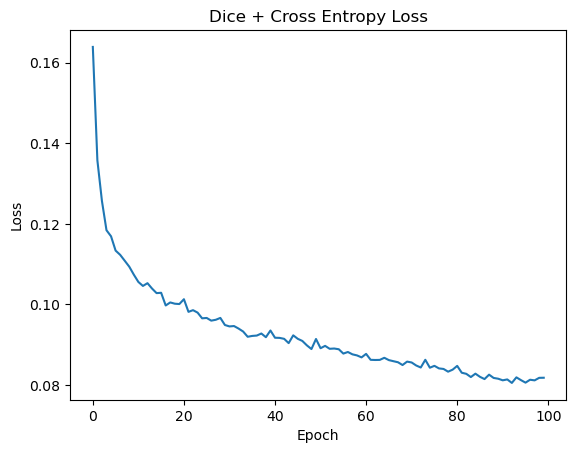

In [11]:
# plot loss
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [95]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
from skimage import io
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)

ts_img_path = '/mnt/dysk_roboczy/fgela/Dataset_BUSI_with_GT/malignant/malignant (173).png'
ts_gt_path = '/mnt/dysk_roboczy/fgela/Dataset_BUSI_with_GT/malignant/malignant (173)_mask.png'
#test_names = sorted(os.listdir(ts_img_path))

# random select a test case
# img_idx = np.random.randint(len(test_names))
# image_data = io.imread(join(ts_img_path, test_names[img_idx]))

image_data = io.imread(ts_img_path)

if image_data.shape[-1]>3 and len(image_data.shape)==3:
    image_data = image_data[:,:,:3]
if len(image_data.shape)==2:
    image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
# read ground truth (gt should have the same name as the image) and simulate a bounding box

def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

gt_data = io.imread(ts_gt_path)
bbox_raw = get_bbox_from_mask(gt_data)


# preprocess: cut-off and max-min normalization

lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)

image_data_pre = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[image_data==0] = 0
image_data_pre = np.uint8(image_data_pre)

H, W, _ = image_data_pre.shape

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data_pre)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)

In [96]:
sam_model.image_encoder.img_size

1024

In [97]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024
sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)

resize_img = sam_transform.apply_image(image_data_pre)
resize_gt = sam_transform.apply_image(gt_data)

resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)

input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)

assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = sam_model.image_encoder(input_image)
    # convert box to 1024x1024 grid
    bbox = sam_trans.apply_boxes(bbox_raw, (H, W))
    print(f'{bbox_raw=} -> {bbox=}')
    box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
    
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    medsam_seg_prob, _ = sam_model.mask_decoder(
        image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    print(medsam_seg.shape)

bbox_raw=array([ 22, 230, 271, 352]) -> bbox=array([[ 39, 411, 484, 629]])
(256, 256)


In [98]:
input_image.shape

torch.Size([1, 3, 1024, 1024])

In [99]:
medsam_seg.shape

(256, 256)

In [100]:
ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)# resize ground truch image

from skimage import transform

r_gt_data = transform.resize(
        gt_data ,
        (256, 256),
        order=0,
        preserve_range=True,
        mode="constant",
    )
medsam_dsc = compute_dice_coefficient(r_gt_data>0, medsam_seg>0)
print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), '\nMedSAM DSC: {:.4f}'.format(medsam_dsc))

Original SAM DSC: 0.8326 
MedSAM DSC: 0.0988


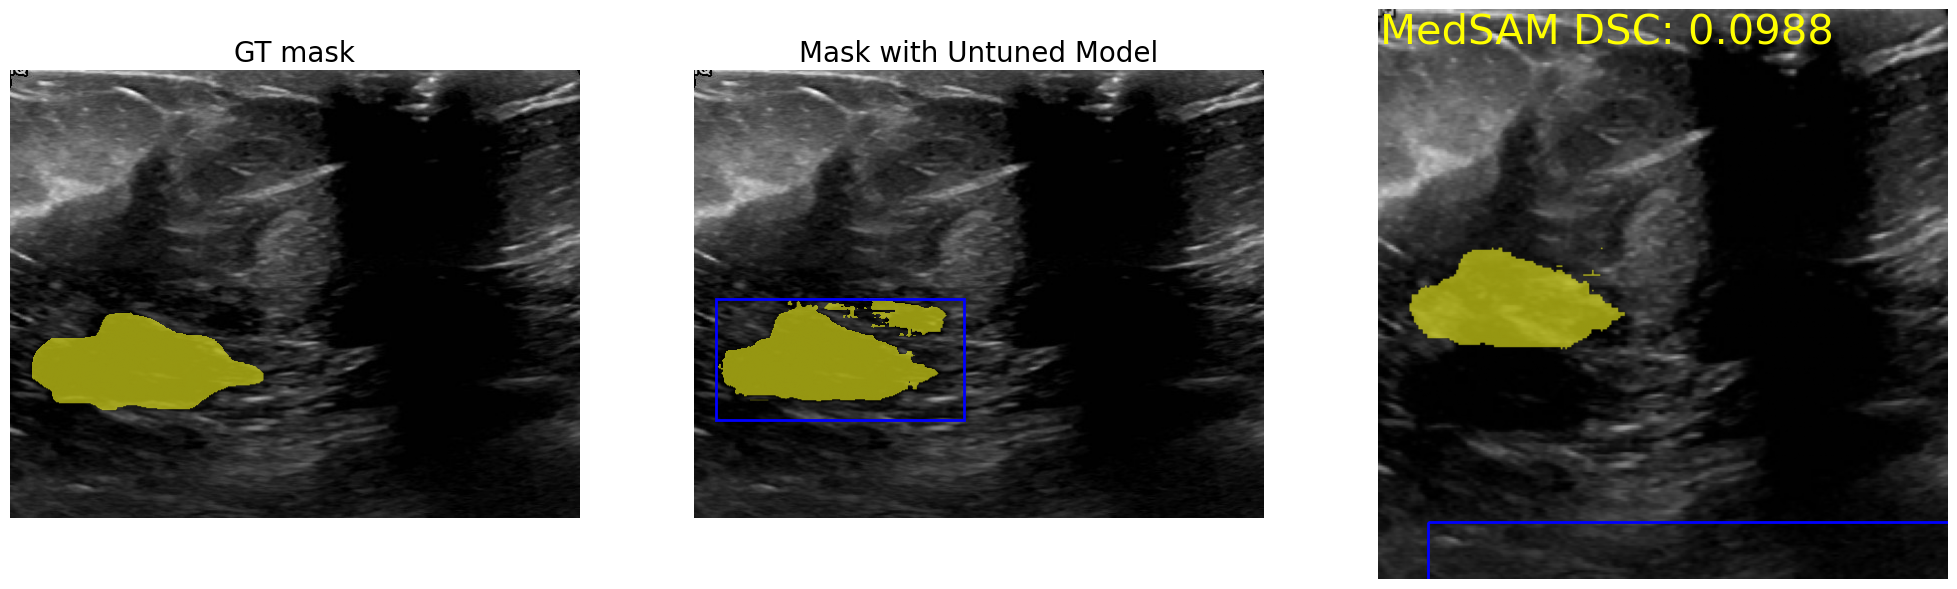

In [101]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(image_data)
show_mask(gt_data>0, axs[0])
# show_box(box_np[img_id], axs[0])
axs[0].set_title('GT mask', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
show_box(bbox_raw, axs[1])
# add text to image to show dice score
# axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(transform.resize(image_data,(256,256)))

show_mask(medsam_seg, axs[2])
show_box(bbox_raw, axs[2])
# add text to image to show dice score
axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
#axs[2].set_title('Mask with tuned model', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()